# Boring Setup Stuff

In [ ]:
!pip install benford_py
!git clone https://github.com/cjph8914/2020_benfords/

In [10]:
import requests

import pandas as pd
import numpy as np
import scipy.stats as stats

from bs4 import BeautifulSoup as bs
from benford import expected as exp
from itertools import tee    
from tabulate import tabulate
from math import log, log10

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
TEST_NAME_MAP = {
  'FDT':    "First Digit Test",
  'SDT':    "Second Digit Test",
  'F2D':    "First Two Digit Test",
  'F3D':    "First Three Digit Test",
  'L2DT':   "Last Two Digit Test"
}

TEST_LEN_MAP = {
  'FDT':    9,
  'SDT':    10,
  'F2D':    99,
  'F3D':    99,
  'L2DT':   100
}

def getDigits(df, n=1, leading=True, onlySingle=False):
  if leading:
    if onlySingle:
      slice_object = slice(n-1,n)
    else:
      slice_object = slice(n)
  else:
    if onlySingle:
      slice_object = slice(-1 *n - 1, -1*n)
    else:
      slice_object = slice(-1 * n, None)
  digitDf = df.apply(lambda x: x.astype(str).str[slice_object]).fillna(0)
  digitDf = digitDf.apply(pd.to_numeric).fillna(0).astype(int)
  return digitDf

def createTestDf(df, operator="FDT"):
    actual ={
        'FDT':  lambda df: getDigits(df, n=1, leading=True, onlySingle=False),
        'SDT':  lambda df: getDigits(df, n=2, leading=True, onlySingle=True),
        'F2D':  lambda df: getDigits(df, n=2, leading=True, onlySingle=False),
        'F3D':  lambda df: getDigits(df, n=3, leading=True, onlySingle=False),
        'L2DT': lambda df: getDigits(df, n=2, leading=False, onlySingle=False)
      }

    expected ={
        'FDT':  lambda: exp.First(1, plot=False),
        'SDT':  lambda: exp.Second(plot=False),
        'F2D':  lambda: exp.First(2, plot=False),
        'F3D':  lambda: exp.First(3, plot=False),
        'L2DT': lambda: exp.LastTwo(plot=False)
      }


    return actual.get(operator)(df), expected.get(operator)()

def getAllTestDfs(df):
  test_keys = ['FDT', 'SDT', 'F2D', 'L2DT'] #'F3D' not relevant here
  test_dfs = {}
  for k in test_keys:
    len_range = TEST_LEN_MAP[k] + 1
    actual, expected = createTestDf(df, k)
    if k == "L2DT":
      expected.loc[expected['Expected'] > 0, 'Expected'] = 0.01
    for c in actual.columns:
      actual[c] = pd.DataFrame(actual[c].value_counts().sort_index())
    actual = actual.reindex(range(1,len_range)).fillna(0)
    test_dfs[k] = {}
    test_dfs[k]["actual"] = actual
    test_dfs[k]["expected"] = expected
  
  return test_dfs

In [12]:
def colPrinter(strings):
  strings_by_column = [s.split('\n') for s in strings]
  strings_by_line = zip(*strings_by_column)
  max_length_by_column = [
      max([len(s) for s in col_strings])
      for col_strings in strings_by_column
  ]
  
  for parts in strings_by_line:
      padded_strings = [
          parts[i].ljust(max_length_by_column[i] + 5)
          for i in range(len(parts))
      ]
      print(''.join(padded_strings))

def plot(dfs, test, title):
  expected = dfs[test]["expected"].reset_index(drop=True)
  actual = dfs[test]["actual"].reset_index(drop=True)
  actual = actual / actual.cumsum().iloc[-1]
  ax = expected.plot(figsize=(7,5), title=title)
  actual.plot.bar(ax = ax)
  plt.show()

In [13]:
class StatTests():
  def chisq(self, df='dataframe', p=None):
      if all(i < 0 for i in df.values.flatten()):
          raise ValueError("The observation counts for each group must be non-negative number")
      if p is None:
          raise ValueError("Please pass the expected values")

      assert df.shape[1] == 1, 'dataframe must one-dimensional contingency table of observed counts'
      assert len(p) == df.shape[0], 'probability values should be equal to observations'
      assert isinstance(p, (tuple, list)) and round(sum(p), 10) == 1, 'probabilities must be list or tuple and ' \
                                                                      'sum to 1'
      df['expected_counts'] = [df.sum()[0] * i for i in p]
      if all(i < 0 for i in p):
          raise ValueError("The probabilities for each group must be non-negative number")
      dof = df.shape[0] - 1
      chi_gf, p_gf = stats.chisquare(f_obs=df[df.columns[0]].to_numpy(), f_exp=df[df.columns[1]].to_numpy())
      return chi_gf, dof, p_gf, df[df.columns[0]].sum()
  
  def runTests(self, dfs, cis=[0.95]):
    self.results = {}
    self.cis = cis
    thresholds = [1.0 - i for i in cis]
    for k in dfs.keys():
      df = dfs[k]["actual"]
      expected = list(dfs[k]["expected"].Expected)
      self.results[k] = []
      for c in df.columns:
        vals = df[[c]].fillna(0)
        if k == "F2D":
          vals = vals.loc[10:].copy()
        elif k == "F3D":
          vals = vals.loc[100:].copy()
        chi_gf, dof, p_gf, ss = self.chisq(df=vals, p=expected)
        data = [c, chi_gf, dof, p_gf, ss]
        for i in range(0, len(thresholds)):
          data.append("Fail" if p_gf < thresholds[i] else "Pass")
        self.results[k].append(data)

  def print(self, n_columns=3):
    strings = []
    headers=["Data", "𝜒2", "Df", "P", "N"]
    for ci in self.cis:
      headers.append(f"P/F @\n {ci}")
    
    for r in self.results:
      strings.append(tabulate([[TEST_NAME_MAP[r]]], tablefmt="psql") +
                     "\n" + tabulate(self.results[r], headers=headers,
                                     tablefmt="psql", numalign="right", floatfmt=("", ".0f", ".f", ".8f")))

    for l in range(0, len(strings), 2):
      if not (l+2 < len(strings)-2):
        colPrinter(strings[l:l+2])
      else: 
        colPrinter(strings[i-1])

In [15]:
def parseMiamiTable(precincts_tables):
  dataset = pd.DataFrame()

  index = 1

  # for each precinct
  for result in precincts_tables:

      # each row is a candidate
      all_candidate_cols = result.find_all('tr')
      
      new_row = {}
          
      # parse the columns
      for i in range(1, len(all_candidate_cols)):
          candidate_cols = all_candidate_cols[i]

          # parse the columns, one is the name the other is the total votes
          col_values = candidate_cols.find_all('td')

          # each row is a candidate starting from 1

          remove_tags = ['REP', 'DEM', 'LPF', 'REF', 'PSL', 'GRE', 'CPF']

          # first column is candidate name, remove superfluous white space
          candidate = col_values[0].text
          for tag in remove_tags:
              candidate = candidate.replace('({})'.format(tag), '')
          candidate = candidate.strip()

          # get the vote count (second to last column)        
          votes = int(col_values[-2].text.replace(',', ''))
          new_row[candidate] = votes


      dataset = dataset.append(pd.Series(new_row, name=index))

      index += 1
  return dataset

def parseMilwTable(precincts_tables):
  precinct = precincts[1]
  dataset = pd.DataFrame()

  # split by table rows
  for tr in precinct.find_all('tr'):
      
      lines = tr.text.split('\n')
      
      # second column is ward name
      ward_name = lines[2]

      # Header line
      if ward_name == "Ward":
          for line in lines[3:]:
              dataset[line] = 0    
      else:
          
          # append row
          new_row = {}
          for i in range(len(dataset.columns)):
              col = dataset.columns[i]
              value = lines[3+i]
              new_row[col] = value

          dataset = dataset.append(pd.Series(new_row, name=ward_name))
  return dataset

def getChicagoData():
  data = pd.read_csv('/content/2020_benfords/data/chicago_dataexport.csv', skiprows=10)
  data = data.dropna()
  data = data[~(data['Precinct'].isin(['Total', 'Precinct']))]
  data = data[['Joseph R. Biden & Kamala D. Harris ',
       'Donald J. Trump & Michael R. Pence ', 
       'Howie Hawkins & Angela Walker ', 
       'Gloria La Riva & Leonard Peltier ', 
       'Brian Carroll & Amar Patel ', 
       "Jo Jorgensen & Jeremy ''Spike'' Cohen "]]
  return data

def getFultonData():
  data =  pd.read_csv('/content/2020_benfords/data/ga_fulton_county.csv', skiprows=2)
  data = data[data.columns[[0, 6, 11, 16]]]
  data.columns = ['Precinct', 'Donald Trump', 'Joe Biden', 'Jo Jorgensen']
  data = data.set_index('Precinct')
  return data

def getAlleghenyData():
  data = pd.read_csv('/content/2020_benfords/data/pa_allegheny_county.csv', skiprows=2)
  data = data[data.columns[[0, 4, 7, 10]]]
  data.columns = ['Precinct', 'Joe Biden','Donald Trump', 'Jo Jorgensen']
  data = data.set_index('Precinct')
  return data

def getMilwaukeeCounty():
  return pd.read_csv("https://raw.githubusercontent.com/FraudAnalysis/Benford2020/main/data/milwaukee_county.csv")

def prepare(df):
  relst = ['Jo', 'Donald']
  df = df.loc[:,df.columns.str.startswith(tuple(relst))]
  df = df.reindex(sorted(df.columns), axis=1)
  df = df.reset_index(drop=True)
  df = df.astype('int64')
  df.columns = ['Trump', 'Jorgensen', 'Biden']
  return df

def getData():
  miami_url = 'https://enr.electionsfl.org/DAD/2779/Precincts/35849/0/865/'

  headers = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
            "(KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}

  r = requests.get(miami_url, headers=headers)
  bs_data = bs(r.text, 'html.parser')
  precincts_tables = bs_data.findAll('table', {'class': 'DetailResults'})
  miami_df = parseMiamiTable(precincts_tables)

  chicago_df = getChicagoData()
  fulton_df = getFultonData()
  allegheny_df = getAlleghenyData()
  milw_df = getMilwaukeeCounty()
  
  dataset = {
      'Milwaukee':  milw_df,
      'MiamiDade':  miami_df,
      'Chicago':    chicago_df,
      'Fulton':     fulton_df,
      'Allegheny':  allegheny_df
  }

  dataset = {county: prepare(dataset[county]) for county in dataset}
  
  return dataset

# The Fun Starts Here

In [16]:
dataset = getData()

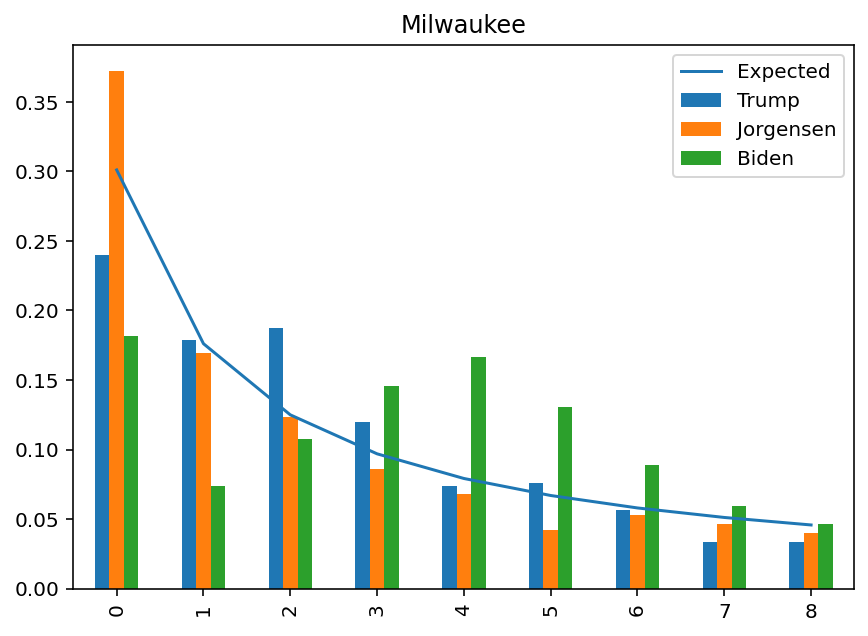

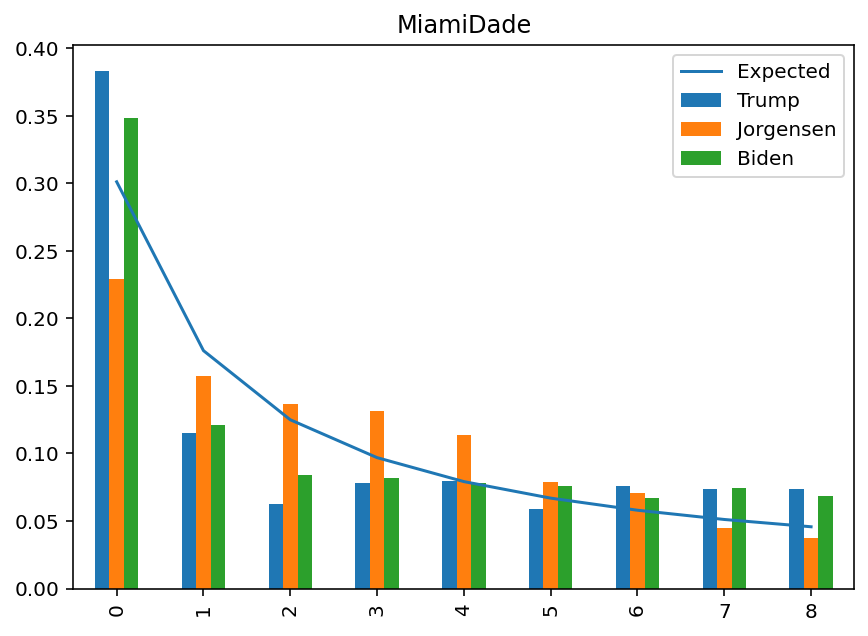

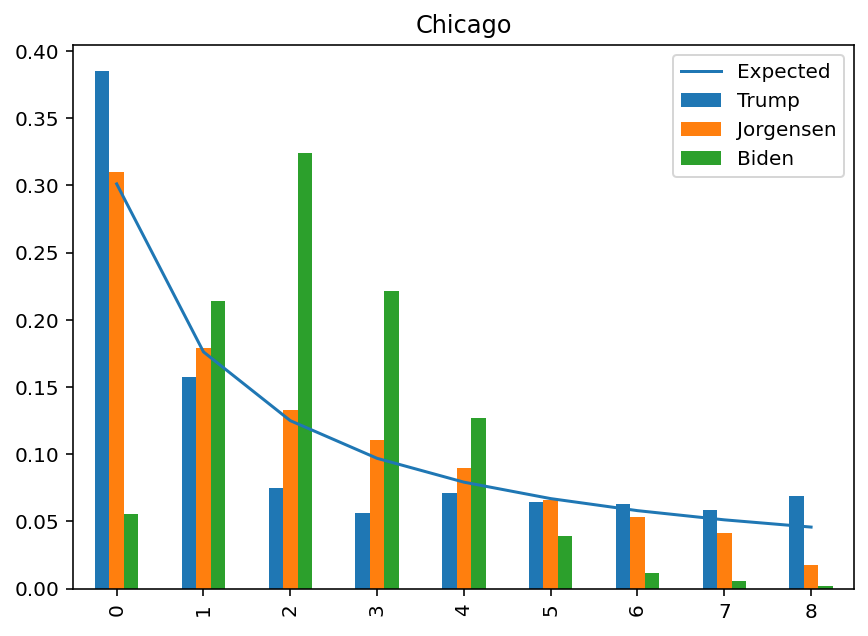

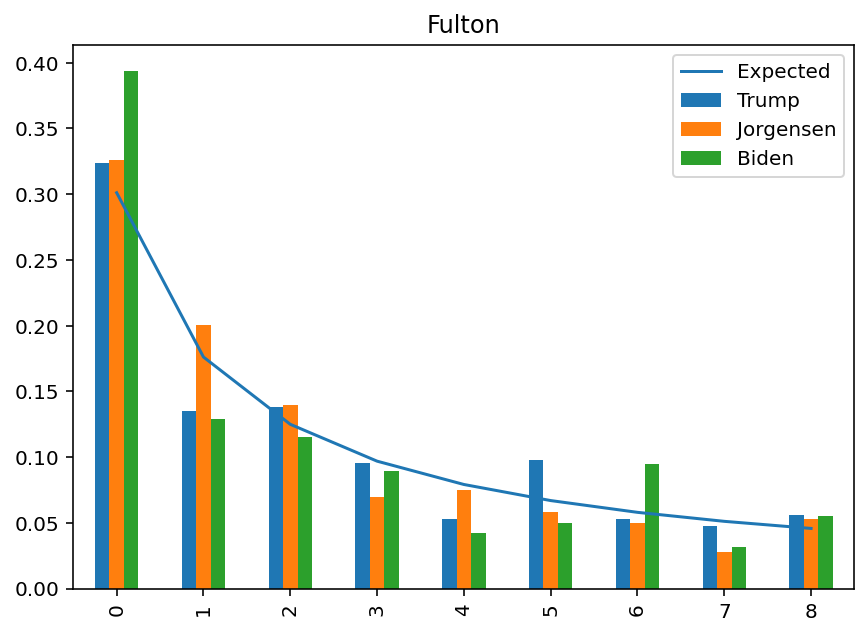

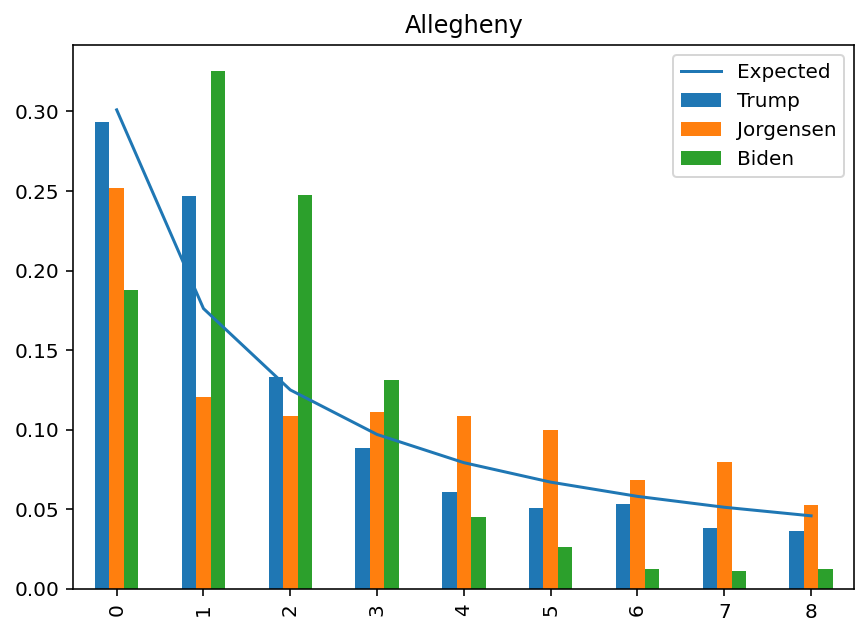

In [17]:
for county in dataset:
  dfs = getAllTestDfs(dataset[county])
  plot(dfs, "FDT", county)

In [19]:
stat_tests = StatTests()
for county in dataset:
  print(county)
  dfs = getAllTestDfs(dataset[county])
  stat_tests.runTests(dfs, cis=[0.95, 0.999, 0.999])
  stat_tests.print(n_columns=2)
  print("\n")

Milwaukee
+------------------+                                                               +-------------------+                                                              
| First Digit Test |                                                               | Second Digit Test |                                                              
+------------------+                                                               +-------------------+                                                              
+-----------+------+------+------------+-----+---------+----------+----------+     +-----------+------+------+------------+-----+---------+----------+----------+     
| Data      |   𝜒2 |   Df |          P |   N | P/F @   | P/F @    | P/F @    |     | Data      |   𝜒2 |   Df |          P |   N | P/F @   | P/F @    | P/F @    |     
|           |      |      |            |     |  0.95   |  0.999   |  0.999   |     |           |      |      |            |     |  0.95   |  0.999   |  0.9